In [1]:
# Stock Prediction Decision Making Notebook
# Interactive notebook for making daily trading decisions

import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Configuration
TOP_N_PICKS = 10
INVESTMENT_AMOUNT = 1000

# Path configuration - adjust for notebook location
# Since notebook is in eda-notebooks/, go up one level to project root
PROJECT_ROOT = Path("..").resolve()  # Go up one level from eda-notebooks/
ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
DATA_DIR = PROJECT_ROOT / "data"
RESULTS_DIR = PROJECT_ROOT / "results"
APP_DIR = PROJECT_ROOT / "app"

print("📊 Stock Prediction Decision Making Notebook")
print("=" * 50)

# Setup paths
if str(APP_DIR) not in sys.path:
    sys.path.append(str(APP_DIR))

print(f"✅ Paths configured:")
print(f"   Project root: {PROJECT_ROOT}")
print(f"   App code: {APP_DIR}")
print(f"   Artifacts: {ARTIFACTS_DIR}")
print(f"   Data: {DATA_DIR}")

📊 Stock Prediction Decision Making Notebook
✅ Paths configured:
   Project root: /Users/sagardhal/Desktop/Practice/personal-stock
   App code: /Users/sagardhal/Desktop/Practice/personal-stock/app
   Artifacts: /Users/sagardhal/Desktop/Practice/personal-stock/artifacts
   Data: /Users/sagardhal/Desktop/Practice/personal-stock/data


In [2]:
# go up one level to the root directory
sys.path.append(os.path.abspath(".."))



# # add project root (parent of notebooks/) to sys.path
# project_root = Path.cwd().parent
# sys.path.insert(0, str(project_root))

from app.predictions import (
    load_latest_data,
    load_model_and_features,
    PredictionComparator,
    _TransformAdapter,
)

# If you also need TrainModel directly in the notebook:
from app.train_model_new import TrainModel   # ✅ absolute package import

from app.stock_pipeline import StockDataPipeline


# Import modules
try:
    from app.predictions import load_model_and_features, _TransformAdapter
    from app.train_model_new import TrainModel
    from app.stock_pipeline import StockDataPipeline
    print("✅ All modules imported successfully")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("Make sure your app directory contains all required modules")

✅ All modules imported successfully


In [3]:
# Step 1: Load Tickers
print("\n" + "=" * 50)
print("STEP 1: LOAD TICKERS")
print("=" * 50)


tickers = (pd.read_csv("/Users/sagardhal/Desktop/Practice/personal-stock/ticker/spx_ndx_liq_top250_latest.csv")['Ticker']
        #.head(5)
        .tolist())
tickers
len(tickers)





STEP 1: LOAD TICKERS


250

In [4]:
# Step 2: Check Requirements
print("\n" + "=" * 50)
print("STEP 2: CHECK REQUIREMENTS")
print("=" * 50)

# Check for trained models
artifacts_files = list(ARTIFACTS_DIR.glob("*.joblib")) + list(ARTIFACTS_DIR.glob("*.pkl"))
print(f"🤖 Models found: {len(artifacts_files)}")
for f in artifacts_files:
    print(f"   - {f.name}")

# Check for data files
data_files = list(DATA_DIR.glob("*.parquet")) if DATA_DIR.exists() else []
print(f"📊 Data files found: {len(data_files)}")
for f in data_files[:3]:
    print(f"   - {f.name}")
if len(data_files) > 3:
    print(f"   ... and {len(data_files) - 3} more files")


STEP 2: CHECK REQUIREMENTS
🤖 Models found: 5
   - best_rf_model.joblib
   - random_forest_train_valid_20250904_112953.joblib
   - random_forest_train_only_20250904_000839.joblib
   - random_forest_train_only_20250904_112906.joblib
   - random_forest_train_valid_20250904_000856.joblib
📊 Data files found: 1
   - stock_data_combined_20250904_071145.parquet


In [5]:
# =============================================================================
# STEP 3: TRANSFORM DATA USING YOUR STOCKDATAPIPELINE
# =============================================================================

print("\n" + "=" * 60)
print("STEP 3: TRANSFORM DATA USING STOCKDATAPIPELINE")
print("=" * 60)

def run_stock_pipeline_for_predictions(tickers):
    """Run your StockDataPipeline to get fully transformed data"""
    print("🚀 Running StockDataPipeline for complete feature engineering...")
    
    # Configuration (same as your run_data_extraction.py)
    config = {
        "LOOKBACKS": [1, 3, 7, 30, 90, 252, 365],
        "HORIZONS": [30],
        "BINARY_THRESHOLDS": {30: 1.00},  # 0% gain threshold
    }
    
    print(f"   Configuration:")
    print(f"   - Lookbacks: {config['LOOKBACKS']}")
    print(f"   - Horizons: {config['HORIZONS']} days")  
    print(f"   - Binary threshold: {config['BINARY_THRESHOLDS'][30]:.0%}")
    
    try:
        # Initialize StockDataPipeline (same as extraction script)
        pipeline = StockDataPipeline(
            tickers=tickers,
            lookbacks=config["LOOKBACKS"],
            horizons=config["HORIZONS"],
            binarize_thresholds=config["BINARY_THRESHOLDS"],
        )
        
        # Run complete pipeline: stock data + technical indicators + macro data
        print("   📊 Running complete pipeline...")
        print("      - Step 1: Fetching stock data")
        print("      - Step 2: Adding technical indicators (TA-Lib)")  
        print("      - Step 3: Adding macro indicators")
        print("      - Step 4: Final validation and cleanup")
        
        transformed_data = pipeline.run_complete_pipeline()
        
        print(f"   ✅ StockDataPipeline complete!")
        print(f"      Final shape: {transformed_data.shape}")
        
        # Get latest data for predictions
        latest_date = transformed_data['Date'].max()
        prediction_data = transformed_data[transformed_data['Date'] == latest_date].copy()
        
        print(f"   📅 Prediction data ready:")
        print(f"      Latest date: {latest_date.date()}")
        print(f"      Stocks: {len(prediction_data)}")
        
        # Show feature categories
        feature_categories = {
            "Basic OHLCV": [c for c in transformed_data.columns if c in ["Date", "Ticker", "Open", "High", "Low", "Close", "Volume"]],
            "Growth Features": [c for c in transformed_data.columns if c.startswith("growth_") and "future" not in c],
            "Technical Indicators": [c for c in transformed_data.columns if any(x in c.lower() for x in ["rsi", "macd", "sma", "adx", "cci"])],
            "Candlestick Patterns": [c for c in transformed_data.columns if c.startswith("cdl")],
            "Macro Features": [c for c in transformed_data.columns if c.endswith(("_yoy", "_qoq")) or "btc" in c.lower() or "vix" in c.lower()],
            "Target Variables": [c for c in transformed_data.columns if "future" in c and ("positive" in c or "growth" in c)],
        }
        
        print(f"\n   📈 Features created:")
        total_features = 0
        for category, features in feature_categories.items():
            print(f"      {category}: {len(features)}")
            total_features += len(features)
        print(f"      Total: {total_features} features")
        
        return transformed_data, prediction_data
        
    except Exception as e:
        print(f"   ❌ StockDataPipeline failed: {e}")
        print(f"   This could be due to:")
        print(f"   - API rate limits from yfinance/FRED")
        print(f"   - Missing TA-Lib dependencies") 
        print(f"   - Network connectivity issues")
        print(f"   - Insufficient historical data")
        raise

# Run StockDataPipeline
try:
    print("🔄 Starting StockDataPipeline transformation...")
    full_data, prediction_data = run_stock_pipeline_for_predictions(tickers)
    
    print("✅ StockDataPipeline transformation complete!")
    print(f"   Ready for model predictions: {len(prediction_data)} stocks")
    
except Exception as e:
    print(f"❌ StockDataPipeline failed: {e}")
    print("\nTroubleshooting:")
    print("1. Check internet connection")
    print("2. Verify TA-Lib is installed: pip install TA-Lib")  
    print("3. Try with fewer tickers (reduce TOP_N_PICKS)")
    print("4. Check yfinance/FRED API limits")
    raise



STEP 3: TRANSFORM DATA USING STOCKDATAPIPELINE
🔄 Starting StockDataPipeline transformation...
🚀 Running StockDataPipeline for complete feature engineering...
   Configuration:
   - Lookbacks: [1, 3, 7, 30, 90, 252, 365]
   - Horizons: [30] days
   - Binary threshold: 100%
   📊 Running complete pipeline...
      - Step 1: Fetching stock data
      - Step 2: Adding technical indicators (TA-Lib)
      - Step 3: Adding macro indicators
      - Step 4: Final validation and cleanup
STOCK MARKET DATA PIPELINE
Processing 250 tickers: NVDA, TSLA, AAPL, PLTR, MSFT, AMD, AMZN, META, GOOGL, UNH, AVGO, GOOG, MSTR, LLY, COIN, NFLX, INTC, APP, ORCL, BRK-B, JPM, COST, V, MU, PANW, CRM, SMCI, GEV, WMT, NOW, BAC, XOM, UBER, BA, MA, INTU, MRVL, JNJ, IBM, CSCO, CRWD, TXN, HD, C, CVX, AMAT, CAT, GS, QCOM, ADBE, PEP, TMO, LRCX, ANET, UNP, GE, ASML, SHOP, WFC, ACN, BKNG, PG, ISRG, MCD, PFE, TMUS, PDD, KO, MRK, PM, SBUX, TTD, ABBV, ADI, DIS, CMG, APH, T, KLAC, VST, DASH, VRTX, ETN, CSX, MELI, COF, PYPL, WDAY

[*********************100%***********************]  250 of 250 completed


Created binary target: is_positive_growth_30d_future (threshold=1.0)
Raw stock data: (2109525, 30)
Date range: 1962-01-02 00:00:00 to 2025-09-12 00:00:00
Tickers: AAPL, ABBV, ABNB, ABT, ACN, ADBE, ADI, ADP, ADSK, AEP, AJG, ALB, AMAT, AMD, AMGN, AMT, AMZN, ANET, AON, APH, APO, APP, ARM, ASML, AVGO, AXON, AXP, AZN, AZO, BA, BAC, BDX, BKNG, BLK, BMY, BRK-B, BSX, BX, C, CAH, CARR, CAT, CB, CCI, CCL, CDNS, CEG, CHTR, CI, CL, CMCSA, CME, CMG, CNC, COF, COIN, COP, COR, COST, CRM, CRWD, CSCO, CSX, CTAS, CVS, CVX, DAL, DASH, DDOG, DE, DECK, DELL, DHI, DHR, DIS, DLTR, DOW, DUK, EA, EBAY, EL, ELV, EMR, EQIX, EQT, ETN, EW, EXPE, F, FCX, FDX, FI, FICO, FSLR, FTNT, GE, GEV, GILD, GLW, GM, GOOG, GOOGL, GS, HBAN, HCA, HD, HLT, HON, HPE, HUM, HWM, IBKR, IBM, ICE, IDXX, INTC, INTU, ISRG, IT, JCI, JNJ, JPM, KDP, KEY, KHC, KKR, KLAC, KMI, KO, KR, KVUE, LEN, LHX, LIN, LLY, LMT, LOW, LRCX, LULU, MA, MAR, MCD, MCHP, MCK, MCO, MDLZ, MDT, MELI, META, MMC, MMM, MNST, MO, MPWR, MRK, MRVL, MS, MSCI, MSFT, MSI, MS

In [76]:
cols = ["growth_btc_1d","growth_btc_7d","growth_btc_30d","growth_btc_90d",
        "growth_vix_1d","growth_vix_7d","growth_vix_30d","growth_vix_90d"]

full_data.query("Date in ['2025-09-08','2025-09-09']")[["Date"]+cols].drop_duplicates()


,Date,growth_btc_1d,growth_btc_7d,growth_btc_30d,growth_btc_90d,growth_vix_1d,growth_vix_7d,growth_vix_30d,growth_vix_90d
11268,2025-09-08,0.008130,0.025820,-0.038016,0.016454,-0.004611,0.017508,0.012056,-0.374845
11269,2025-09-09,-0.004826,0.002967,-0.065178,0.026166,-0.004633,0.042273,0.000665,-0.391093


In [6]:
# =============================================================================
# STEP 4: PREPARE FOR MODEL INFERENCE USING TRAINMODEL
# =============================================================================

print("\n" + "=" * 60)
print("STEP 4: PREPARE FOR MODEL INFERENCE")
print("=" * 60)

import pandas as pd  # ensure available for Timedelta/to_datetime

def prepare_for_model_inference(pipeline_data, window_days=7):
    """Use TrainModel to prepare StockDataPipeline output for inference."""
    print("🤖 Using TrainModel for inference preparation...")
    try:
        # Create adapter and TrainModel (consistent with predictions.py)
        adapter = _TransformAdapter(pipeline_data)
        tm = TrainModel(adapter)

        # Prepare for inference (creates dummy variables, etc.)
        tm.prepare_dataframe(start_date="2000-01-01")

        print(f"   ✅ TrainModel preparation complete")
        print(f"      Shape: {tm.df_full.shape}")

        # ---- Slice to last `window_days` calendar days (with hardening) ----
        # Safety: ensure Date is datetime
        tm.df_full['Date'] = pd.to_datetime(tm.df_full['Date'])

        latest_date = tm.df_full['Date'].max()
        week_start = latest_date - pd.Timedelta(days=window_days - 1)

        inference_data = tm.df_full[
            (tm.df_full['Date'] >= week_start) &
            (tm.df_full['Date'] <= latest_date)
        ].copy()

        if inference_data.empty:
            raise ValueError(
                f"No inference rows between {week_start.date()} and {latest_date.date()}. "
                "Check upstream dates/timezones or reduce window_days."
            )
        # --------------------------------------------------------------------

        print(f"   📊 Inference window: {week_start.date()} → {latest_date.date()}  |  Rows: {len(inference_data)}")

        return tm, inference_data

    except Exception as e:
        print(f"   ❌ TrainModel preparation failed: {e}")
        raise

try:
    # Prepare data for inference (last 7 calendar days)
    tm, inference_data = prepare_for_model_inference(full_data, window_days=7)

    # Load trained model
    print("\n📂 Loading trained model...")
    model, feature_cols, target_col = load_model_and_features(str(ARTIFACTS_DIR))

    print(f"✅ Model loaded:")
    print(f"   Type: {type(model).__name__}")
    print(f"   Features expected: {len(feature_cols)}")
    print(f"   Target: {target_col}")

    # Set up TrainModel for inference (same as predictions.py)
    tm.model = model
    tm._inference_feature_columns = feature_cols
    if target_col:
        tm.target_col = target_col

    print("✅ Model setup complete")

except Exception as e:
    print(f"❌ Model setup or prediction failed: {e}")
    print("Make sure you have a trained model in the artifacts directory")
    print("Run: python run_model_training.py --mode basic")
    raise



STEP 4: PREPARE FOR MODEL INFERENCE
🤖 Using TrainModel for inference preparation...
Preparing dataframe for modeling...
Defining feature sets...
Feature Set Summary:
  Growth features: 70
  Technical indicators: 56
  Technical patterns: 61
  Custom numerical: 7
  Macro features: 75
  Categorical (for dummies): 7
  Target columns: 2
  Total numerical features: 206
  Unused columns: 0
Creating dummy variables...
Created 397 dummy variables
Sample dummies: ['month_1', 'month_10', 'month_11', 'month_12', 'month_2']
Filtered data from 2000-01-01
Date range: 2000-01-03 00:00:00 to 2025-09-12 00:00:00
Temporal split created:
  train: 909,539 samples
  validation: 232,029 samples
  test: 238,866 samples
Creating ML datasets...
Total features before filtering: 603
  - Numerical: 206
  - Dummies: 397
Features after removing 'future': 603
Selected target: is_positive_growth_30d_future
ML Dataset Summary:
  Features used: 603
  Train: 909,539 samples
  Validation: 232,029 samples
  Test: 238,866 

In [7]:
print(f"Debug info:")
print(f"   Data shape: {tm.df_full.shape if hasattr(tm, 'df_full') else 'N/A'}")
if 'feature_cols' in locals() and hasattr(tm, 'df_full'):
    available = [f for f in feature_cols if f in tm.df_full.columns]
    missing = [f for f in feature_cols if f not in tm.df_full.columns]
    print(f"   Available features (sample): {available}")
    print(f"   Missing features (sample): {missing}")


Debug info:
   Data shape: (1380434, 620)
   Available features (sample): ['growth_1d', 'growth_3d', 'growth_7d', 'growth_30d', 'growth_90d', 'growth_252d', 'growth_365d', 'growth_btc_1d', 'growth_btc_3d', 'growth_btc_7d', 'growth_btc_30d', 'growth_btc_90d', 'growth_btc_252d', 'growth_btc_365d', 'growth_vix_1d', 'growth_vix_3d', 'growth_vix_7d', 'growth_vix_30d', 'growth_vix_90d', 'growth_vix_252d', 'growth_vix_365d', 'growth_dax_1d', 'growth_dax_3d', 'growth_dax_7d', 'growth_dax_30d', 'growth_dax_90d', 'growth_dax_252d', 'growth_dax_365d', 'growth_snp500_1d', 'growth_snp500_3d', 'growth_snp500_7d', 'growth_snp500_30d', 'growth_snp500_90d', 'growth_snp500_252d', 'growth_snp500_365d', 'growth_dji_1d', 'growth_dji_3d', 'growth_dji_7d', 'growth_dji_30d', 'growth_dji_90d', 'growth_dji_252d', 'growth_dji_365d', 'growth_epi_1d', 'growth_epi_3d', 'growth_epi_7d', 'growth_epi_30d', 'growth_epi_90d', 'growth_epi_252d', 'growth_epi_365d', 'growth_gold_1d', 'growth_gold_3d', 'growth_gold_7d', 'gr

In [14]:
# =============================================================================
# COMPLETE PREDICTION GENERATOR CLASS DEFINITION
# =============================================================================

import pandas as pd
import numpy as np
from typing import List, Dict, Optional

class CompletePredictionGenerator:
    """
    Generates all prediction types used in your simulation analysis:
    - ML probabilities and thresholds
    - Manual rule-based predictions  
    - Ensemble combinations
    """
    
    def __init__(self, data: pd.DataFrame, model, feature_cols: List[str]):
        self.data = data.copy()
        self.model = model
        self.feature_cols = feature_cols
        self.prediction_cols = []
        
    def generate_all_predictions(self) -> pd.DataFrame:
        """Generate complete set of predictions matching your simulation analysis"""
        print("Generating complete prediction set...")
        
        # 1. Generate ML predictions
        self._generate_ml_predictions()
        
        # 2. Generate manual rule-based predictions
        self._generate_manual_predictions()
        
        # 3. Generate ensemble predictions
        self._generate_ensemble_predictions()
        
        print(f"Generated {len(self.prediction_cols)} prediction strategies")
        return self.data
    
    def _generate_ml_predictions(self):
        """Generate ML-based predictions with multiple thresholds"""
        print("  Generating ML predictions...")
        
        # Generate base probabilities
        X = self._prepare_feature_matrix()
        probabilities = self.model.predict_proba(X)[:, 1]
        self.data['rf_prob_30d'] = probabilities
        
        # Fixed threshold strategies
        thresholds = [0.20, 0.50,0.55,0.6, 0.65,0.7,0.75 ,0.80, 0.85,0.90]
        for i, threshold in enumerate(thresholds):
            col_name = f'pred{10 + i}_rf_thresh_{int(threshold * 100)}'
            self.data[col_name] = (probabilities >= threshold).astype(int)
            self.prediction_cols.append(col_name)
        
        # Dynamic threshold strategies (based on validation quantiles)
        self._generate_adaptive_thresholds(probabilities)
        
        # Daily top-K strategies
        self._generate_topk_strategies(probabilities)
    
    def _generate_adaptive_thresholds(self, probabilities):
        """Generate adaptive thresholds based on quantiles"""
        target_rates = [0.01, 0.03, 0.05]  # 1%, 3%, 5% selection rates
        
        for i, rate in enumerate(target_rates):
            threshold = np.quantile(probabilities, 1.0 - rate)
            col_name = f'pred{15 + i}_rf_auto_rate_{int(rate * 100)}p'
            self.data[col_name] = (probabilities >= threshold).astype(int)
            self.prediction_cols.append(col_name)
    
    def _generate_topk_strategies(self, probabilities):
        """Generate daily top-K strategies"""
        if 'Date' in self.data.columns:
            for k in [3, 5, 10]:
                col_name = f'pred{30 + k//3}_top{k}_daily'
                
                # Group by date and select top K per date
                top_k_mask = (
                    self.data.groupby('Date')['rf_prob_30d']
                    .rank(method='first', ascending=False)
                    .le(k)
                    .astype(int)
                )
                self.data[col_name] = top_k_mask
                self.prediction_cols.append(col_name)
    
    def _generate_manual_predictions(self):
        """Generate manual rule-based predictions"""
        print("  Generating manual rule-based predictions...")
        
        # pred0: CCI momentum breakout
        if 'cci' in self.data.columns:
            self.data['pred0_manual_cci'] = (
                pd.to_numeric(self.data['cci'], errors='coerce').fillna(0) > 200
            ).astype(int)
            self.prediction_cols.append('pred0_manual_cci')
        
        # pred1: Previous 30d growth momentum
        growth_30d_col = self._find_growth_column(['growth_30d'])
        if growth_30d_col:
            self.data['pred1_manual_prev_g1'] = (
                pd.to_numeric(self.data[growth_30d_col], errors='coerce').fillna(0) > 1
            ).astype(int)
            self.prediction_cols.append('pred1_manual_prev_g1')
        
        # pred2: Combined stock and S&P500 momentum
        snp_col = self._find_growth_column(['growth_snp500_30d', 'growth_snp_30d'])
        if growth_30d_col and snp_col:
            stock_momentum = pd.to_numeric(self.data[growth_30d_col], errors='coerce').fillna(0) > 1
            snp_momentum = pd.to_numeric(self.data[snp_col], errors='coerce').fillna(0) > 1
            self.data['pred2_manual_prev_g1_and_snp'] = (stock_momentum & snp_momentum).astype(int)
            self.prediction_cols.append('pred2_manual_prev_g1_and_snp')
        
        # pred3: Declining interest rates environment
        dgs10_col = self._find_column(['dgs10_yoy'])
        dgs5_col = self._find_column(['dgs5_yoy'])
        if dgs10_col and dgs5_col:
            dgs10_declining = pd.to_numeric(self.data[dgs10_col], errors='coerce').fillna(0) < 0
            dgs5_declining = pd.to_numeric(self.data[dgs5_col], errors='coerce').fillna(0) < 0
            self.data['pred3_manual_declining_rates'] = (dgs10_declining & dgs5_declining).astype(int)
            self.prediction_cols.append('pred3_manual_declining_rates')
        
        # pred4: Federal Reserve easing cycle
        fedfunds_col = self._find_column(['fedfunds_yoy'])
        if fedfunds_col:
            self.data['pred4_manual_fed_easing'] = (
                pd.to_numeric(self.data[fedfunds_col], errors='coerce').fillna(0) < -0.1
            ).astype(int)
            self.prediction_cols.append('pred4_manual_fed_easing')
        
        # pred5: VIX contrarian signal (fear spike = buy opportunity)
        vix_col = self._find_growth_column(['growth_vix_30d'])
        if vix_col:
            self.data['pred5_manual_vix_contrarian'] = (
                pd.to_numeric(self.data[vix_col], errors='coerce').fillna(0) > 0.2
            ).astype(int)
            self.prediction_cols.append('pred5_manual_vix_contrarian')
        
        # pred6: Combined stock and Bitcoin momentum
        btc_col = self._find_growth_column(['growth_btc_30d'])
        if growth_30d_col and btc_col:
            stock_momentum = pd.to_numeric(self.data[growth_30d_col], errors='coerce').fillna(0) > 1.0
            btc_momentum = pd.to_numeric(self.data[btc_col], errors='coerce').fillna(0) > 1.0
            self.data['pred6_manual_stock_btc_momentum'] = (stock_momentum & btc_momentum).astype(int)
            self.prediction_cols.append('pred6_manual_stock_btc_momentum')
    
    def _generate_ensemble_predictions(self):
        """Generate ensemble predictions combining manual and ML"""
        print("  Generating ensemble predictions...")
        
        manual_preds = [c for c in self.prediction_cols if 'manual' in c]
        ml_mid = [c for c in self.prediction_cols if 'rf_thresh_50' in c]
        ml_auto = [c for c in self.prediction_cols if 'rf_auto_rate_' in c]
        topk_preds = [c for c in self.prediction_cols if 'top' in c and 'daily' in c]
        
        # Ensemble A: ML confidence + momentum confirmation
        if ml_mid and 'pred1_manual_prev_g1' in manual_preds:
            ml_signal = self.data[ml_mid[0]] == 1
            momentum_signal = self.data['pred1_manual_prev_g1'] == 1
            self.data['pred20_ens_ml50_and_momentum'] = (ml_signal & momentum_signal).astype(int)
            self.prediction_cols.append('pred20_ens_ml50_and_momentum')
        
        # Ensemble B: High conviction ML OR daily top picks
        auto_1p = [c for c in ml_auto if c.endswith('_1p')]
        if auto_1p and topk_preds:
            auto_signal = self.data[auto_1p[0]] == 1
            top_signal = self.data[topk_preds[0]] == 1  # Use first top-K strategy
            self.data['pred21_ens_auto1p_or_top3'] = (auto_signal | top_signal).astype(int)
            self.prediction_cols.append('pred21_ens_auto1p_or_top3')
        
        # Ensemble C: Majority manual rules + ML confirmation
        if len(manual_preds) >= 3:
            manual_sum = self.data[manual_preds].sum(axis=1)
            auto_3p = [c for c in ml_auto if c.endswith('_3p')]
            if auto_3p:
                manual_majority = manual_sum >= 2
                ml_confirmation = self.data[auto_3p[0]] == 1
                self.data['pred22_ens_manual2plus_and_auto3p'] = (manual_majority & ml_confirmation).astype(int)
                self.prediction_cols.append('pred22_ens_manual2plus_and_auto3p')
    
    def _prepare_feature_matrix(self):
        """Prepare feature matrix for ML model"""
        # Build feature matrix matching training features
        missing_features = []
        X_cols = []
        
        for col in self.feature_cols:
            if col in self.data.columns:
                X_cols.append(self.data[col])
            else:
                missing_features.append(col)
                X_cols.append(pd.Series(0, index=self.data.index))
        
        if missing_features:
            print(f"    Warning: {len(missing_features)} features missing, filled with 0")
        
        X = pd.DataFrame(dict(zip(self.feature_cols, X_cols)), index=self.data.index)
        
        # Clean data
        X = X.replace([np.inf, -np.inf], np.nan)
        X = X.fillna(X.median(numeric_only=True)).fillna(0)
        X = X.astype(np.float32, copy=False)
        
        return X
    
    def _find_column(self, candidates: List[str]) -> Optional[str]:
        """Find first existing column from candidates"""
        for col in candidates:
            if col in self.data.columns:
                return col
        return None
    
    def _find_growth_column(self, candidates: List[str]) -> Optional[str]:
        """Find growth column, trying exact match first, then partial"""
        # Try exact matches first
        for col in candidates:
            if col in self.data.columns:
                return col
        
        # Try partial matches
        for candidate in candidates:
            for col in self.data.columns:
                if candidate.replace('growth_', '') in col and 'growth' in col:
                    return col
        
        return None

# Integration function
def generate_complete_predictions(prediction_data, model, feature_cols):
    """
    Main function to generate complete prediction set
    """
    print("Generating complete prediction set...")
    
    # Initialize generator
    generator = CompletePredictionGenerator(prediction_data, model, feature_cols)
    
    # Generate all predictions
    enhanced_data = generator.generate_all_predictions()
    
    # Print summary
    print(f"Total strategies generated: {len(generator.prediction_cols)}")
    
    return enhanced_data, generator.prediction_cols

In [15]:
# =============================================================================
# STEP 5: GENERATE COMPLETE PREDICTIONS (ML + MANUAL + ENSEMBLE)  
# =============================================================================

print("\n" + "=" * 60)
print("STEP 5: GENERATE COMPLETE PREDICTIONS")
print("=" * 60)

# Ensure we have the date range defined
if 'week_start' not in locals():
    latest_date = tm.df_full['Date'].max()
    week_start = latest_date - pd.Timedelta(days=6)  # Last 7 days
    print(f"Defining date range: {week_start.date()} to {latest_date.date()}")

try:
    # Generate complete prediction set matching simulation analysis
    enhanced_data, all_prediction_cols = generate_complete_predictions(
        prediction_data=tm.df_full[tm.df_full['Date'] >= week_start],
        model=model,
        feature_cols=feature_cols
    )
    
    # Update prediction data to use enhanced version
    latest_date = enhanced_data['Date'].max()
    latest_slice = enhanced_data[enhanced_data['Date'] == latest_date].copy()
    
    print(f"Enhanced prediction data ready: {len(latest_slice)} stocks")
    print(f"Available strategies: {len(all_prediction_cols)}")

except Exception as e:
    print(f"Enhanced prediction generation failed: {e}")
    print("Using basic ML predictions only")
    
    # Fallback - use existing data
    enhanced_data = tm.df_full
    latest_date = enhanced_data['Date'].max()
    latest_slice = enhanced_data[enhanced_data['Date'] == latest_date].copy()
    all_prediction_cols = ['rf_prob_30d']  # Fallback


STEP 5: GENERATE COMPLETE PREDICTIONS
Generating complete prediction set...
Generating complete prediction set...
  Generating ML predictions...
  Generating manual rule-based predictions...
  Generating ensemble predictions...
Generated 26 prediction strategies
Total strategies generated: 26
Enhanced prediction data ready: 250 stocks
Available strategies: 26


In [18]:
pred_cols = [col for col in all_prediction_cols if col.startswith("pred")]
pred_cols

['pred10_rf_thresh_20',
 'pred11_rf_thresh_50',
 'pred12_rf_thresh_55',
 'pred13_rf_thresh_60',
 'pred14_rf_thresh_65',
 'pred15_rf_thresh_70',
 'pred16_rf_thresh_75',
 'pred17_rf_thresh_80',
 'pred18_rf_thresh_85',
 'pred19_rf_thresh_90',
 'pred15_rf_auto_rate_1p',
 'pred16_rf_auto_rate_3p',
 'pred17_rf_auto_rate_5p',
 'pred31_top3_daily',
 'pred31_top5_daily',
 'pred33_top10_daily',
 'pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_declining_rates',
 'pred4_manual_fed_easing',
 'pred5_manual_vix_contrarian',
 'pred6_manual_stock_btc_momentum',
 'pred20_ens_ml50_and_momentum',
 'pred21_ens_auto1p_or_top3',
 'pred22_ens_manual2plus_and_auto3p']

In [20]:
cols_to_choose =  ['Date',
 'Open',
 'High',
 'Low',
 'Close',
 'adj_close',
 'Volume',
 'Ticker',
 'growth_future_30d',
 'is_positive_growth_30d_future',
  'rf_prob_30d'] + pred_cols


new_df = enhanced_data[cols_to_choose]
new_df.tail()

,Date,Open,High,Low,Close,adj_close,Volume,Ticker,growth_future_30d,is_positive_growth_30d_future,...,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_declining_rates,pred4_manual_fed_easing,pred5_manual_vix_contrarian,pred6_manual_stock_btc_momentum,pred20_ens_ml50_and_momentum,pred21_ens_auto1p_or_top3,pred22_ens_manual2plus_and_auto3p
2109520,2025-09-08,152.500000,152.970001,146.490005,151.750000,151.750000,3313000.0,ZTS,0.005998,0,...,0,0,0,0,1,0,0,0,0,0
2109521,2025-09-09,151.410004,152.119995,149.639999,149.789993,149.789993,1952600.0,ZTS,0.005972,0,...,0,0,0,0,1,0,0,0,0,0
2109522,2025-09-10,149.000000,150.580002,148.380005,149.419998,149.419998,2734300.0,ZTS,0.005961,0,...,0,0,0,0,1,0,0,0,0,0
2109523,2025-09-11,149.779999,152.000000,149.419998,150.610001,150.610001,3194000.0,ZTS,0.005836,0,...,0,1,0,0,1,0,0,0,0,0
2109524,2025-09-12,149.649994,150.050003,146.539993,148.199997,148.199997,3111200.0,ZTS,0.005904,0,...,0,1,0,0,1,0,0,1,0,0


In [21]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1250 entries, 11268 to 2109524
Data columns (total 37 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Date                               1250 non-null   datetime64[ns]
 1   Open                               1250 non-null   float64       
 2   High                               1250 non-null   float64       
 3   Low                                1250 non-null   float64       
 4   Close                              1250 non-null   float64       
 5   adj_close                          1250 non-null   float64       
 6   Volume                             1250 non-null   float64       
 7   Ticker                             1250 non-null   object        
 8   growth_future_30d                  1250 non-null   float64       
 9   is_positive_growth_30d_future      1250 non-null   int64         
 10  rf_prob_30d                       

In [22]:
import numpy as np
import pandas as pd

# --- 1) Define predictor buckets --------------------------------------------
rf_thresh_cols = [
    'pred10_rf_thresh_21','pred11_rf_thresh_50','pred12_rf_thresh_65',
    'pred13_rf_thresh_80','pred14_rf_thresh_90',
    'pred15_rf_auto_rate_1p','pred16_rf_auto_rate_3p','pred17_rf_auto_rate_5p'
]

topN_cols = ['pred31_top3_daily','pred31_top5_daily','pred33_top10_daily']

manual_cols = [
    'pred0_manual_cci','pred1_manual_prev_g1','pred2_manual_prev_g1_and_snp',
    'pred3_manual_declining_rates','pred4_manual_fed_easing',
    'pred5_manual_vix_contrarian','pred6_manual_stock_btc_momentum'
]

ensemble_cols = ['pred20_ens_ml50_and_momentum','pred21_ens_auto1p_or_top3','pred22_ens_manual2plus_and_auto3p']

# Choose which sets to include in each “vote family”
vote_sets = {
    # everything
    'all_pred': rf_thresh_cols + topN_cols + manual_cols + ensemble_cols,
    # model-ish (rf thresholds + topN + ensemble)
    'modelish': rf_thresh_cols + topN_cols + ensemble_cols,
    # models only (no manual and no ensemble built from manual) – keep it pure if you want
    'models_only': rf_thresh_cols + topN_cols,
    # manual only
    'manual_only': manual_cols,
    # blended: rf med+high thresholds + ensemble + a couple robust manual rules
    'blended': ['pred11_rf_thresh_50','pred12_rf_thresh_65','pred13_rf_thresh_80'] + ensemble_cols + [
        'pred0_manual_cci','pred2_manual_prev_g1_and_snp'
    ],
}

# --- 2) Utility: clean & clip to {0,1} --------------------------------------
def _as_binary(df, cols):
    cols = [c for c in cols if c in df.columns]
    out = df[cols].copy()
    # Try to coerce to numeric, then clip
    for c in cols:
        out[c] = pd.to_numeric(out[c], errors='coerce')
    return out.fillna(0).clip(lower=0, upper=1)

# --- 3) Core voting function -------------------------------------------------
def build_voting_signals(
    df: pd.DataFrame,
    vote_sets: dict,
    vote_threshold: float = 0.5,
    min_votes: int = 3,
    tie_breaker_col: str = 'rf_prob_30d',   # optional soft tiebreaker
    tie_breaker_cut: float = 0.5
):
    """
    For each key in vote_sets:
      - computes vote_count, possible_count, vote_share
      - produces signal_{name} ∈ {0,1}
      - produces strength_{name} ∈ {'WEAK','MODERATE','STRONG'}
    """
    out = df.copy()
    for name, cols in vote_sets.items():
        bin_df = _as_binary(out, cols)
        vote_count = bin_df.sum(axis=1)
        possible_count = bin_df.shape[1] if bin_df.shape[1] > 0 else 1
        vote_share = (vote_count / possible_count)

        # base decision
        signal = (vote_share >= vote_threshold) & (vote_count >= min_votes)

        # optional tiebreaker around the threshold edge
        if tie_breaker_col in out.columns:
            near_edge = (vote_share.between(vote_threshold - 0.05, vote_threshold + 0.05))
            # if near edge, nudge using the probability column
            signal = np.where(
                near_edge & (out[tie_breaker_col] > tie_breaker_cut),
                1,
                signal.astype(int)
            )

        # strength buckets from vote_share (tweak as you like)
        strength = pd.cut(
            vote_share,
            bins=[-np.inf, 0.33, 0.6, 1.01],  # looser
            labels=['WEAK','MODERATE','STRONG']
        )

        out[f'vote_count_{name}'] = vote_count.astype(int)
        out[f'vote_possible_{name}'] = possible_count
        out[f'vote_share_{name}'] = vote_share
        out[f'signal_{name}'] = signal.astype(int)
        out[f'strength_{name}'] = strength.astype(str)

    return out

# # --- 4) Run it ----------------------------------------------------------------
# voted_df = build_voting_signals(
#     new_df,
#     vote_sets=vote_sets,
#     vote_threshold=0.55,   # a bit stricter than 0.5
#     min_votes=3,           # avoid single-flag triggers
#     tie_breaker_col='rf_prob_30d',
#     tie_breaker_cut=0.55
# )

# voted_df.tail()


In [25]:
# Step 1: define your top-3 strategies
top3_cols = ['pred15_rf_auto_rate_3p','pred15_rf_auto_rate_5p']
vote_sets_top3 = {"top3": top3_cols}


# Make sure Date column is datetime
new_df["Date"] = pd.to_datetime(new_df["Date"])

# Find the most recent date in your dataset
latest_date = new_df["Date"].max()

# Filter to that day only (≈ your daily “stock universe” snapshot)
latest_df = new_df.loc[new_df["Date"] == latest_date].copy()

print("Latest date:", latest_date.date(),
      "| rows:", len(latest_df),
      "| unique tickers:", latest_df["Ticker"].nunique())


# Step 2: Build signals on the latest snapshot
latest_voted_top3 = build_voting_signals(
    latest_df,             # latest date df from earlier
    vote_sets=vote_sets_top3,
    vote_threshold=0.67,   # require 2 out of 3
    min_votes=2,           # at least 2 predictors must agree
    tie_breaker_col='rf_prob_30d',
    tie_breaker_cut=0.55
)

# Step 3: Rank tickers by signal & conviction
ranked_top3 = (
    latest_voted_top3
      .assign(
          _sig = latest_voted_top3["signal_top3"].values,
          _strength_ord = latest_voted_top3["strength_top3"].map({"STRONG":2,"MODERATE":1,"WEAK":0}).fillna(0).values,
          _share = latest_voted_top3["vote_share_top3"].values,
          _prob = latest_voted_top3["rf_prob_30d"].values
      )
      .sort_values(by=["_sig","_strength_ord","_share","_prob"], ascending=[False,False,False,False])
      .reset_index(drop=True)
)

# Step 4: Take top N picks (say 20)
TOP_N = 20
top_picks= ranked_top3.head(TOP_N)

# Final table
top_picks[["Date","Ticker","Close","rf_prob_30d",
                "vote_count_top3","vote_share_top3",
                "signal_top3","strength_top3"]]


Latest date: 2025-09-12 | rows: 250 | unique tickers: 250


,Date,Ticker,Close,rf_prob_30d,vote_count_top3,vote_share_top3,signal_top3,strength_top3
0,2025-09-12,KVUE,18.990000,0.523272,0,0.0,0,WEAK
1,2025-09-12,AMT,195.080002,0.520900,0,0.0,0,WEAK
2,2025-09-12,BMY,46.200001,0.520504,0,0.0,0,WEAK
3,2025-09-12,PFE,23.870001,0.520420,0,0.0,0,WEAK
4,2025-09-12,KDP,27.230000,0.520030,0,0.0,0,WEAK
5,2025-09-12,CNC,33.259998,0.519950,0,0.0,0,WEAK
6,2025-09-12,CCI,95.389999,0.519647,0,0.0,0,WEAK
7,2025-09-12,LULU,159.869995,0.519526,0,0.0,0,WEAK
8,2025-09-12,INTC,24.080000,0.519327,0,0.0,0,WEAK
9,2025-09-12,DOW,25.040001,0.518987,0,0.0,0,WEAK


In [28]:
import os
import pandas as pd

def save_latest_predictions_simple(latest_df: pd.DataFrame, vote_family: str, out_dir: str = "pred_logs"):
    """
    Saves a minimal snapshot (Date, Ticker, Close, probability, signal) for the latest day.
    Assumes latest_df already contains signal columns for the chosen vote_family.
    """
    os.makedirs(out_dir, exist_ok=True)

    fam = vote_family
    cols = [c for c in [
        "Date","Ticker","Close","rf_prob_30d",
        f"signal_{fam}", f"vote_share_{fam}", f"strength_{fam}"
    ] if c in latest_df.columns]

    snap = latest_df[cols].copy().reset_index(drop=True)

    asof = pd.to_datetime(snap["Date"].max()).strftime("%Y-%m-%d")
    csv_path = os.path.join(out_dir, f"predictions_{fam}_asof_{asof}.csv")
    pq_path  = os.path.join(out_dir, f"predictions_{fam}_asof_{asof}.parquet")

    snap.to_csv(csv_path, index=False)
    try:
        snap.to_parquet(pq_path, index=False)
    except Exception as e:
        print("Parquet save skipped:", e)

    print(f"Saved:\n  {csv_path}\n  {pq_path if os.path.exists(pq_path) else '(parquet skipped)'}")
    return snap

# Example:
# save_latest_predictions_simple(latest_voted_top3, vote_family="top3")


In [35]:
import os
import pandas as pd
import numpy as np

def save_latest_predictions_simple_rank(
    df: pd.DataFrame,
    vote_sets: dict,
    vote_family: str,
    vote_threshold: float = 0.6,
    min_votes: int = 2,
    tie_breaker_col: str = "rf_prob_30d",
    tie_breaker_cut: float = 0.55,
    out_dir: str = "../new_pred_logs"
):
    os.makedirs(out_dir, exist_ok=True)

    # --- 1) get latest date ---
    tmp = df.copy()
    if "Date" not in tmp.columns:
        raise KeyError("Input df must contain a 'Date' column.")

    tmp["Date"] = pd.to_datetime(tmp["Date"], errors="coerce")
    latest_date = tmp["Date"].max()
    if pd.isna(latest_date):
        print("No valid dates found in df; returning empty result.")
        return pd.DataFrame()

    latest_df = tmp.loc[tmp["Date"] == latest_date].copy()
    if latest_df.empty:
        print(f"No rows found for latest date {latest_date}; returning empty result.")
        return pd.DataFrame()

    # --- 2) build signals ---
    voted = build_voting_signals(
        latest_df,
        vote_sets=vote_sets,
        vote_threshold=vote_threshold,
        min_votes=min_votes,
        tie_breaker_col=tie_breaker_col,
        tie_breaker_cut=tie_breaker_cut
    )

    fam = vote_family
    fam_cols = [f"signal_{fam}", f"vote_share_{fam}", f"strength_{fam}"]
    missing = [c for c in fam_cols if c not in voted.columns]

    if missing:
        # help the user see what *is* available
        families_available = sorted({
            col.split("_", 1)[1]
            for col in voted.columns
            if col.startswith(("signal_", "vote_share_", "strength_")) and "_" in col
        })
        raise KeyError(
            f"Missing expected columns for family '{fam}': {missing}. "
            f"Available families detected: {families_available}. "
            f"Make sure vote_family matches the key in vote_sets and what build_voting_signals outputs."
        )

    # --- columns we want to carry forward ---
    base_needed = ["Date", "Ticker", "Close", "rf_prob_30d"]
    needed = base_needed + fam_cols
    available = [c for c in needed if c in voted.columns]
    snap = voted[available].copy().reset_index(drop=True)

    # --- 3) map strength to numeric order for sorting ---
    # normalize case just in case ("weak", "Weak", etc.)
    s_col = f"strength_{fam}"
    if s_col in snap.columns:
        snap[s_col] = snap[s_col].astype(str).str.upper()
    strength_map = {"STRONG": 2, "MODERATE": 1, "WEAK": 0}
    snap["_strength_ord"] = snap.get(s_col, pd.Series(index=snap.index)).map(strength_map).fillna(0).astype(int)

    # --- 4) sort & rank ---
    sort_cols = ["_strength_ord"]
    ascending = [False]

    if "rf_prob_30d" in snap.columns:
        sort_cols.append("rf_prob_30d")
        ascending.append(False)
    else:
        print("Warning: 'rf_prob_30d' not found; sorting only by strength.")

    snap_sorted = snap.sort_values(by=sort_cols, ascending=ascending).reset_index(drop=True)
    snap_sorted["rank_today"] = np.arange(1, len(snap_sorted) + 1)

    # --- 5) reorder nicely (keep rank first; move any missing aside gracefully) ---
    ordered_cols = ["rank_today","Date","Ticker","Close","rf_prob_30d",
                    f"signal_{fam}", f"vote_share_{fam}", f"strength_{fam}"]
    snap_sorted = snap_sorted[[c for c in ordered_cols if c in snap_sorted.columns]]

    # --- 6) save ---
    asof = pd.to_datetime(latest_date).strftime("%Y-%m-%d")
    csv_path = os.path.join(out_dir, f"predictions_{fam}_asof_{asof}.csv")
    pq_path  = os.path.join(out_dir, f"predictions_{fam}_asof_{asof}.parquet")

    snap_sorted.to_csv(csv_path, index=False)
    try:
        snap_sorted.to_parquet(pq_path, index=False)
    except Exception as e:
        print("Parquet save skipped:", e)

    print(f"Saved predictions to:\n  {csv_path}\n  {pq_path if os.path.exists(pq_path) else '(parquet skipped)'}")
    return snap_sorted


In [36]:
vote_sets_top3 = {"top2": ['pred16_rf_auto_rate_3p','pred17_rf_auto_rate_5p']}

today_ranked = save_latest_predictions_simple_rank(
    new_df,
    vote_sets=vote_sets_top3,
    vote_family="top2",
    vote_threshold=0.67,
    min_votes=2,
    out_dir="../new_pred_logs"
)

today_ranked


Saved predictions to:
  ../new_pred_logs/predictions_top2_asof_2025-09-12.csv
  ../new_pred_logs/predictions_top2_asof_2025-09-12.parquet


,rank_today,Date,Ticker,Close,rf_prob_30d,signal_top2,vote_share_top2,strength_top2
0,1,2025-09-12,KVUE,18.990000,0.523272,0,0.0,WEAK
1,2,2025-09-12,AMT,195.080002,0.520900,0,0.0,WEAK
2,3,2025-09-12,BMY,46.200001,0.520504,0,0.0,WEAK
3,4,2025-09-12,PFE,23.870001,0.520420,0,0.0,WEAK
4,5,2025-09-12,KDP,27.230000,0.520030,0,0.0,WEAK
...,...,...,...,...,...,...,...,...
245,246,2025-09-12,BA,215.940002,0.509432,0,0.0,WEAK
246,247,2025-09-12,SHW,360.100006,0.509346,0,0.0,WEAK
247,248,2025-09-12,HCA,405.130005,0.508998,0,0.0,WEAK
248,249,2025-09-12,AVGO,359.869995,0.508762,0,0.0,WEAK


<Axes: >

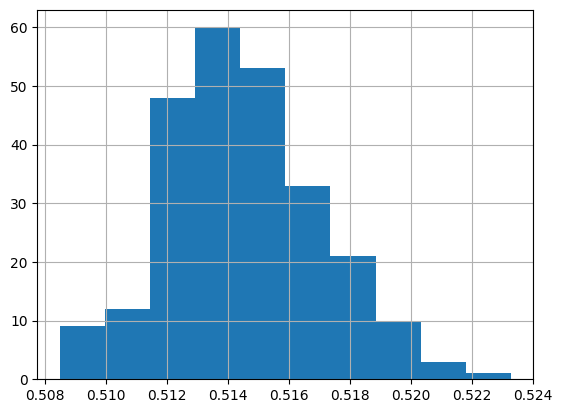

In [38]:
today_ranked.rf_prob_30d.hist()

In [39]:
# =============================================================================
# STEP 5: GENERATE COMPLETE PREDICTIONS (ML + MANUAL + ENSEMBLE)  - full data
# =============================================================================

print("\n" + "=" * 60)
print("STEP 5: GENERATE COMPLETE PREDICTIONS - Full Data")
print("=" * 60)

# Ensure we have the date range defined
if 'week_start' not in locals():
    latest_date = tm.df_full['Date'].max()
    week_start = latest_date - pd.Timedelta(days=6)  # Last 7 days
    print(f"Defining date range: {week_start.date()} to {latest_date.date()}")

try:
    # Generate complete prediction set matching simulation analysis
    enhanced_data, all_prediction_cols = generate_complete_predictions(
        prediction_data=tm.df_full.copy(),
        model=model,
        feature_cols=feature_cols
    )
    
    # Update prediction data to use enhanced version
    latest_date = enhanced_data['Date'].max()
    latest_slice = enhanced_data[enhanced_data['Date'] == latest_date].copy()
    
    print(f"Enhanced prediction data ready: {len(latest_slice)} stocks")
    print(f"Available strategies: {len(all_prediction_cols)}")

except Exception as e:
    print(f"Enhanced prediction generation failed: {e}")
    print("Using basic ML predictions only")
    
    # Fallback - use existing data
    enhanced_data = tm.df_full
    latest_date = enhanced_data['Date'].max()
    latest_slice = enhanced_data[enhanced_data['Date'] == latest_date].copy()
    all_prediction_cols = ['rf_prob_30d']  # Fallback


STEP 5: GENERATE COMPLETE PREDICTIONS - Full Data
Generating complete prediction set...
Generating complete prediction set...
  Generating ML predictions...
  Generating manual rule-based predictions...
  Generating ensemble predictions...
Generated 26 prediction strategies
Total strategies generated: 26
Enhanced prediction data ready: 250 stocks
Available strategies: 26


<Axes: >

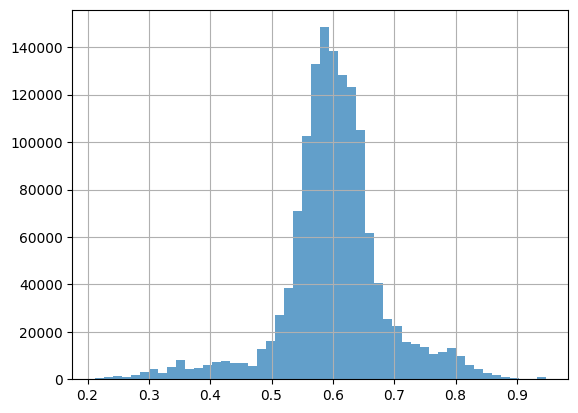

In [52]:
enhanced_data["rf_prob_30d"].hist(bins=50, alpha=0.7)


<Axes: >

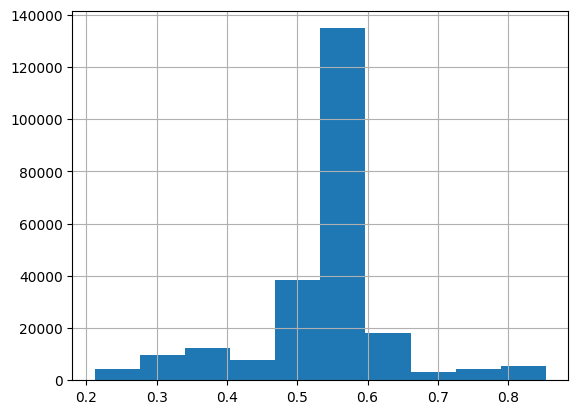

In [58]:
enhanced_data.query('split == "test"').rf_prob_30d.hist()

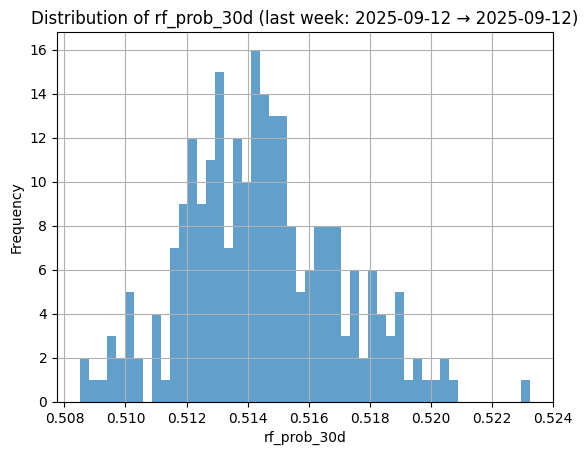

In [59]:
import matplotlib.pyplot as plt
import pandas as pd

# Get the latest date in your prediction data
latest_date = enhanced_data["Date"].max()

# Define start of the latest week
time_start = latest_date - pd.Timedelta(days=0)

# Filter to only the latest week
latest_data = enhanced_data.query("Date >= @time_start")

# Plot histogram
latest_data["rf_prob_30d"].hist(bins=50, alpha=0.7)
plt.xlabel("rf_prob_30d")
plt.ylabel("Frequency")
plt.title(f"Distribution of rf_prob_30d (last week: {time_start.date()} → {latest_date.date()})")
plt.show()


In [60]:
last_date = enhanced_data["Date"].max()
prev_date = enhanced_data.loc[enhanced_data["Date"] < last_date, "Date"].max()

print("Last date:", last_date)
print("Previous date:", prev_date)


Last date: 2025-09-12 00:00:00
Previous date: 2025-09-11 00:00:00


In [62]:
X_last = enhanced_data.loc[enhanced_data["Date"] == last_date, feature_cols]
X_prev = enhanced_data.loc[enhanced_data["Date"] == prev_date, feature_cols]


In [63]:
print("NaNs on last date:\n", X_last.isna().sum().sort_values(ascending=False).head(20))
print("\nColumns with only one unique value (constant):\n", X_last.nunique().loc[lambda x: x <= 1])


NaNs on last date:
 growth_1d      0
Ticker_ON      0
Ticker_ORLY    0
Ticker_OTIS    0
Ticker_OXY     0
Ticker_PANW    0
Ticker_PCG     0
Ticker_PDD     0
Ticker_PEP     0
Ticker_PFE     0
Ticker_PG      0
Ticker_PGR     0
Ticker_PH      0
Ticker_PLD     0
Ticker_PLTR    0
Ticker_PM      0
Ticker_PWR     0
Ticker_ORCL    0
Ticker_NXPI    0
Ticker_QCOM    0
dtype: int64

Columns with only one unique value (constant):
 growth_btc_1d             1
growth_btc_3d             1
growth_btc_7d             1
growth_btc_30d            1
growth_btc_90d            1
                         ..
month_wom_September_w1    1
month_wom_September_w2    1
month_wom_September_w3    1
month_wom_September_w4    1
month_wom_September_w5    1
Length: 247, dtype: int64


In [64]:
train = enhanced_data.loc[enhanced_data["split"]=="train", feature_cols]

train_stats = train.describe().T[["mean","std"]]
last_stats  = X_last.describe().T[["mean","std"]]

compare = train_stats.join(last_stats, lsuffix="_train", rsuffix="_last")
print(compare.head(20))


                 mean_train  std_train  mean_last      std_last
growth_1d          1.000674   0.024700   0.994287  1.877032e-02
growth_3d          1.001999   0.042233   1.007122  5.075162e-02
growth_7d          1.004580   0.062956   1.014335  6.992760e-02
growth_30d         1.019190   0.128028   1.028909  1.179616e-01
growth_90d         1.058864   0.237184   1.143826  2.575834e-01
growth_252d        1.176210   0.661679   1.248726  5.960564e-01
growth_365d        1.264124   0.972166   1.287767  7.771417e-01
growth_btc_1d      0.004973   0.018473   0.005143  0.000000e+00
growth_btc_3d      0.035015   0.032764   0.040985  0.000000e+00
growth_btc_7d      0.044672   0.048098   0.049259  0.000000e+00
growth_btc_30d    -0.020316   0.148190  -0.058718  0.000000e+00
growth_btc_90d     0.157173   0.293405   0.100777  0.000000e+00
growth_btc_252d    0.423095   1.134455   0.183413  2.781125e-17
growth_btc_365d    1.247567   1.569454   0.997377  2.224900e-16
growth_vix_1d      0.002123   0.069657  

In [66]:
import numpy as np
dup_ratio = 1 - np.unique(pd.util.hash_pandas_object(X_last.fillna(-999))).shape[0] / X_last.shape[0]
print(f"Share of duplicate rows on last date: {dup_ratio:.2%}")


Share of duplicate rows on last date: 0.00%


           Date      mean       std       p10       p90
6453 2025-08-29  0.538722  0.002847  0.534962  0.542368
6454 2025-09-02  0.537048  0.002892  0.533044  0.540691
6455 2025-09-03  0.538408  0.002929  0.534296  0.542306
6456 2025-09-04  0.538509  0.002624  0.535306  0.541708
6457 2025-09-05  0.526044  0.002539  0.522850  0.529150
6458 2025-09-08  0.534021  0.002642  0.530828  0.537224
6459 2025-09-09  0.536396  0.002449  0.533129  0.539656
6460 2025-09-10  0.514085  0.002292  0.511011  0.516987
6461 2025-09-11  0.497859  0.002441  0.494680  0.501033
6462 2025-09-12  0.514478  0.002532  0.511644  0.517998


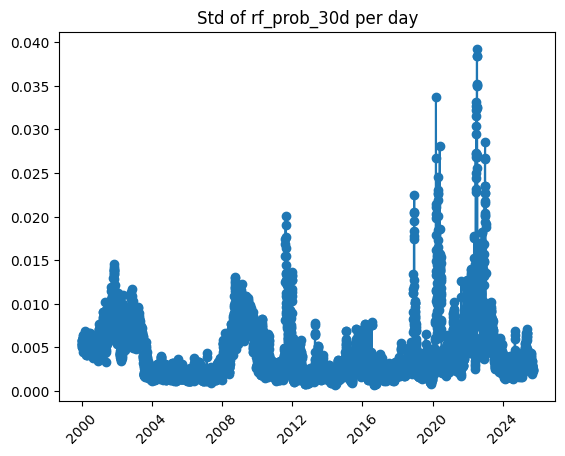

In [68]:
by_day = (
    enhanced_data.groupby("Date")["rf_prob_30d"]
    .agg(mean="mean", std="std", p10=lambda s: s.quantile(0.1), p90=lambda s: s.quantile(0.9))
    .reset_index()
)

print(by_day.tail(10))

import matplotlib.pyplot as plt
plt.plot(by_day["Date"], by_day["std"], marker="o")
plt.title("Std of rf_prob_30d per day")
plt.xticks(rotation=45)
plt.show()


In [69]:
last_date = enhanced_data["Date"].max()
prev_date = enhanced_data.loc[enhanced_data["Date"] < last_date, "Date"].max()

X_last = enhanced_data.loc[enhanced_data["Date"] == last_date, feature_cols]
X_prev = enhanced_data.loc[enhanced_data["Date"] == prev_date, feature_cols]

# Compare variance
var_last = X_last.var(numeric_only=True)
var_prev = X_prev.var(numeric_only=True)

collapsed = var_last[var_last < 1e-8].index.tolist()
print("Collapsed features on last date:", collapsed[:20], "… total:", len(collapsed))


Collapsed features on last date: ['growth_btc_1d', 'growth_btc_3d', 'growth_btc_7d', 'growth_btc_30d', 'growth_btc_90d', 'growth_btc_252d', 'growth_btc_365d', 'growth_vix_1d', 'growth_vix_3d', 'growth_vix_7d', 'growth_vix_30d', 'growth_vix_90d', 'growth_vix_252d', 'growth_vix_365d', 'growth_dax_1d', 'growth_dax_3d', 'growth_dax_7d', 'growth_dax_30d', 'growth_dax_90d', 'growth_dax_252d'] … total: 247


In [71]:
check_date = pd.to_datetime("2025-09-09")

X_check = enhanced_data.loc[enhanced_data["Date"] == check_date, feature_cols]
print(f"Shape for {check_date.date()}:", X_check.shape)


collapsed = X_check.nunique().loc[lambda x: x <= 1]
print(f"Collapsed features on {check_date.date()} (first 20 shown):")
print(collapsed.head(20))
print(f"Total collapsed features: {len(collapsed)}")



Shape for 2025-09-09: (250, 603)
Collapsed features on 2025-09-09 (first 20 shown):
growth_btc_1d      1
growth_btc_3d      1
growth_btc_7d      1
growth_btc_30d     1
growth_btc_90d     1
growth_btc_252d    1
growth_btc_365d    1
growth_vix_1d      1
growth_vix_3d      1
growth_vix_7d      1
growth_vix_30d     1
growth_vix_90d     1
growth_vix_252d    1
growth_vix_365d    1
growth_dax_1d      1
growth_dax_3d      1
growth_dax_7d      1
growth_dax_30d     1
growth_dax_90d     1
growth_dax_252d    1
dtype: int64
Total collapsed features: 243


In [72]:
btc_cols  = [c for c in X_check.columns if "btc" in c]
vix_cols  = [c for c in X_check.columns if "vix" in c]
dax_cols  = [c for c in X_check.columns if "dax" in c]

print("BTC growth features on", check_date.date(), "\n", X_check[btc_cols].head())
print("VIX growth features on", check_date.date(), "\n", X_check[vix_cols].head())
print("DAX growth features on", check_date.date(), "\n", X_check[dax_cols].head())


BTC growth features on 2025-09-09 
        growth_btc_1d  growth_btc_3d  growth_btc_7d  growth_btc_30d  \
11269      -0.004826       0.011847       0.002967       -0.065178   
14457      -0.004826       0.011847       0.002967       -0.065178   
15645      -0.004826       0.011847       0.002967       -0.065178   
27106      -0.004826       0.011847       0.002967       -0.065178   
33174      -0.004826       0.011847       0.002967       -0.065178   

       growth_btc_90d  growth_btc_252d  growth_btc_365d  
11269        0.026166         0.193744         0.956006  
14457        0.026166         0.193744         0.956006  
15645        0.026166         0.193744         0.956006  
27106        0.026166         0.193744         0.956006  
33174        0.026166         0.193744         0.956006  
VIX growth features on 2025-09-09 
        growth_vix_1d  growth_vix_3d  growth_vix_7d  growth_vix_30d  \
11269      -0.004633      -0.016993       0.042273        0.000665   
14457      -0.00463